I write this notebook because I am learning time series techniques. This notebook pulls insights from the time series training data. Apparently they only record children's physical movement activities. These data are complimentary to training data. When they are not active in physical movement, they are active on intelnet. It helps answer the following four questions:

1. How are the features distributed?
2. How are the numerical variables varied in response to time_of_day or weekday?
3. How many counts do numerical features have by weekdays?
4. Other interesting plots. 

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Importing Libraries</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Loading Data</p>

Take first id 00115b9f as an example. 

In [2]:
df = pd.read_parquet("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=00115b9f/part-0.parquet")
df.drop('step', axis=1, inplace=True)
df

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43325,-0.008333,-0.023620,-1.006901,0.007224,-88.595741,0.0,0.000000,3824.000000,57580000000000,6,3,85.0
43326,0.048730,-0.076725,-0.953776,0.056839,-85.352219,0.0,0.000000,3824.000000,57640000000000,6,3,85.0
43327,0.387370,0.793151,-0.402214,0.069961,-24.097908,0.0,0.000000,3824.000000,57645000000000,6,3,85.0
43328,0.801953,0.501589,-0.040937,0.045489,-2.113776,0.0,0.000000,3824.000000,57650000000000,6,3,85.0


# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Data Exploration</p>

Data descriptions:

Series are used as training data, partitioned by id. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

id - The patient identifier corresponding to the id field in train/test.csv.

step - An integer timestep for each observation within a series.

X, Y, Z - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.

enmo - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

anglez - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.

non-wear_flag - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.

light - Measure of ambient light in lux. See ​​here for details.

battery_voltage - A measure of the battery voltage in mV.

time_of_day - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.

weekday - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.

quarter - The quarter of the year, an integer from 1 to 4.

relative_date_PCIAT - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

In [3]:
df.describe()

,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.0,43330.000000,43330.000000,4.333000e+04,43330.000000,43330.0,43330.000000
mean,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.0,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683
std,0.453665,0.502702,0.585710,0.106351,42.947170,0.0,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244914
min,-1.746094,-2.905339,-1.048372,0.000000,-89.833092,0.0,0.000000,3824.000000,5.500000e+10,1.000000,3.0,41.000000
25%,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.000000,3.0,42.000000
50%,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.000000,5.347750e+13,5.000000,3.0,50.000000
75%,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.000000,3.0,53.000000
max,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.500000,8.611000e+13,7.000000,3.0,85.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43330 entries, 0 to 43329
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    43330 non-null  float32
 1   Y                    43330 non-null  float32
 2   Z                    43330 non-null  float32
 3   enmo                 43330 non-null  float32
 4   anglez               43330 non-null  float32
 5   non-wear_flag        43330 non-null  float32
 6   light                43330 non-null  float32
 7   battery_voltage      43330 non-null  float32
 8   time_of_day          43330 non-null  int64  
 9   weekday              43330 non-null  int8   
 10  quarter              43330 non-null  int8   
 11  relative_date_PCIAT  43330 non-null  float32
dtypes: float32(9), int64(1), int8(2)
memory usage: 1.9 MB


The 'quarter' coloumn has only one value: 3.

In [5]:
df['quarter'].unique()

array([3], dtype=int8)

The 'non-wear_flag' coloumn has only one value: 0.

In [6]:
df['non-wear_flag'].unique()

array([0.], dtype=float32)

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Q1. How are the features distributed? </p>

'X', 'Y', 'Z' (Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis) show similar patterns. Most active regions lie within (-1, 1). Both 'enmo' and 'light' have very large outliers. See the differences between '%75's (0,04; 15) and 'max's(4; 2633). 'non-wear_flag'(0) means watch is being worn. Measurements are distributed along all 7 weekdays in quarter 3 only. Positive 'relative_date_PCIAT' days indicate that the actigraphy data have been collected after the test is administered.

<Figure size 1500x1200 with 0 Axes>

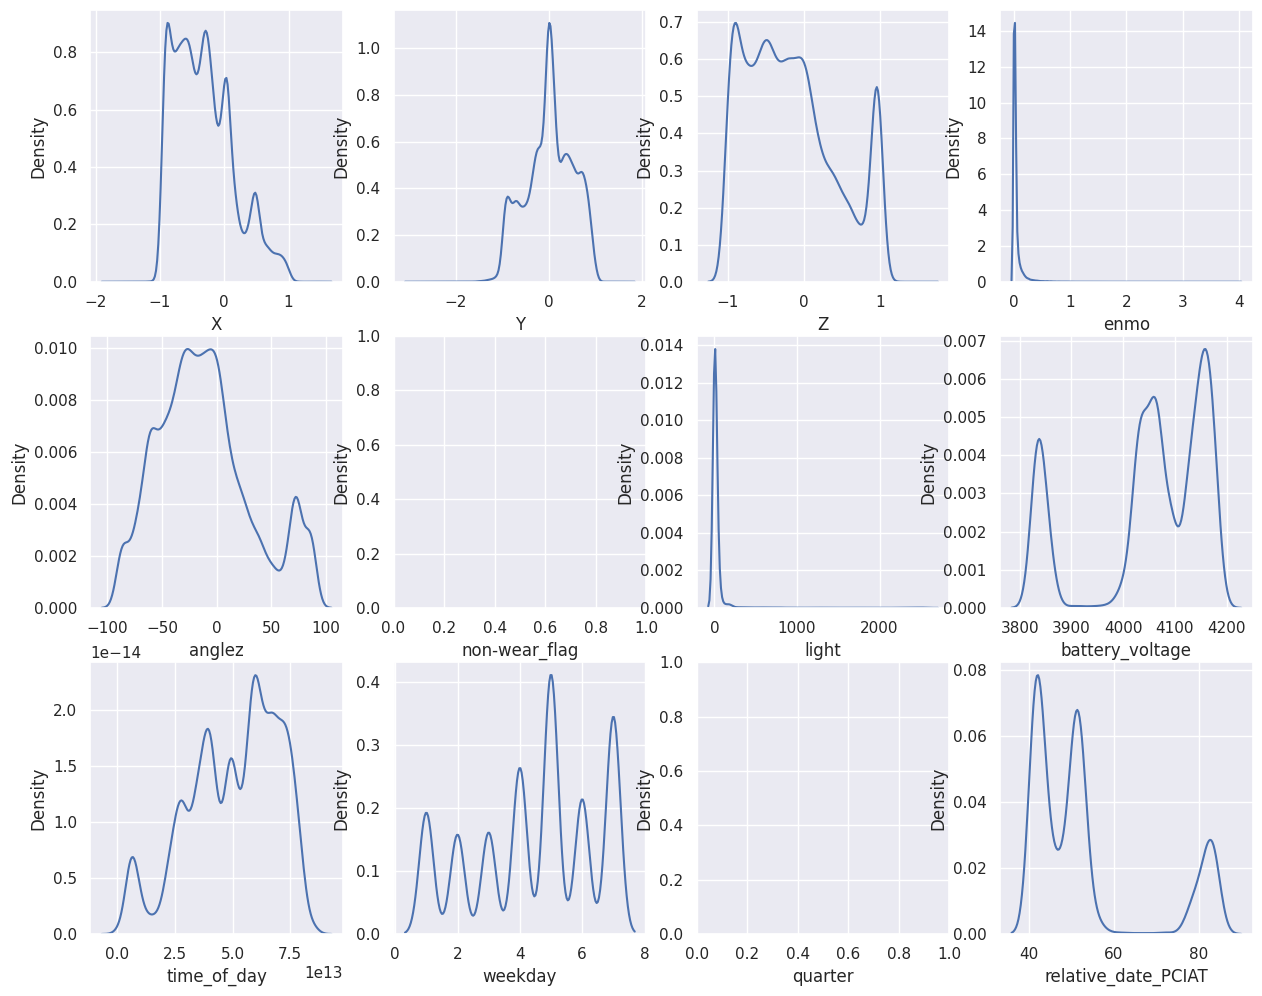

In [7]:
sns.set_theme(rc={'figure.figsize':(15,12)})
plt.figure(figsize=(15,12))

fig, axes = plt.subplots(3, 4)
for i in range(3):
    for j in range(4):
        sns.kdeplot(ax=axes[i,j], data=df, x=df.columns[i*4+j])

Two columns 'enmo' and 'light' show non-Gaussian distributions. After log transformation, they look more like Gaussian distributions. Skewnesses are also reduced. "1" is added to deal with the 0 values in the columns.

In [8]:
df['enmo'] = np.log(1 + df['enmo'])
df['light'] = np.log(1 + df['light'])

<Axes: xlabel='light', ylabel='Density'>

<Figure size 1000x500 with 0 Axes>

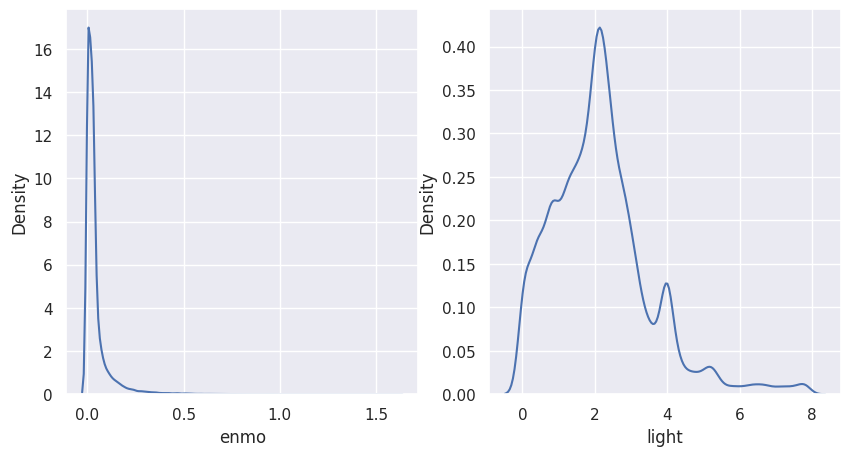

In [9]:
sns.set_theme(rc={'figure.figsize':(10,5)})
plt.figure(figsize=(10,5))

fig, axes = plt.subplots(1, 2)
sns.kdeplot(ax=axes[0], data=df, x='enmo')
sns.kdeplot(ax=axes[1], data=df, x='light')

I add another feature 'cubic_root' to describe the geometric mean accelaration along 3 standard axes. Clearly it shows a nearly symmetric distribution along 0.0 axis.

<Axes: xlabel='geo_mean', ylabel='Density'>

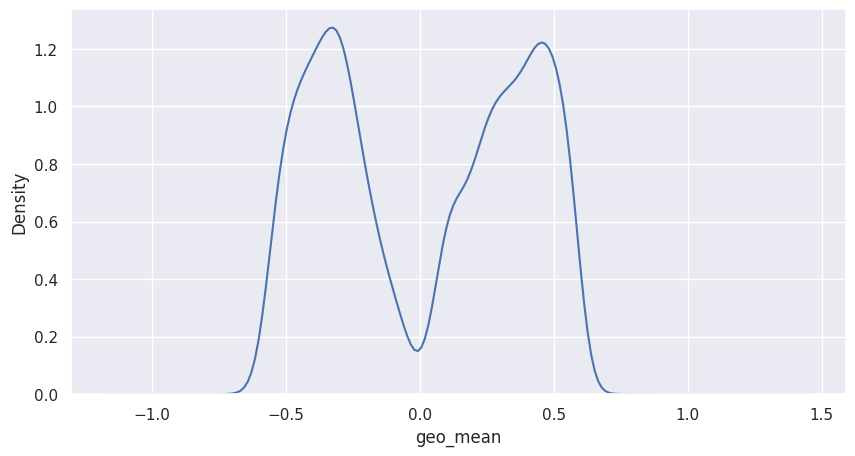

In [10]:
df['geo_mean'] = np.cbrt(df['X'] * df['Y'] * df['Z'])

fig, ax = plt.subplots(1, 1)
sns.kdeplot(ax=ax, data=df, x='geo_mean')

Below are the QQ-plots and histogram distributions, with skewnesses printed on the figures.

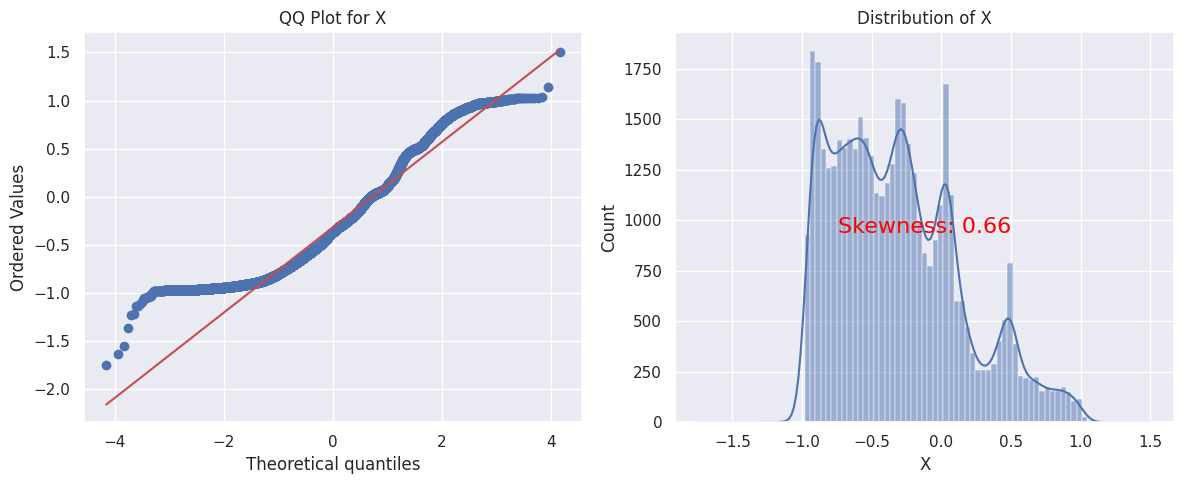

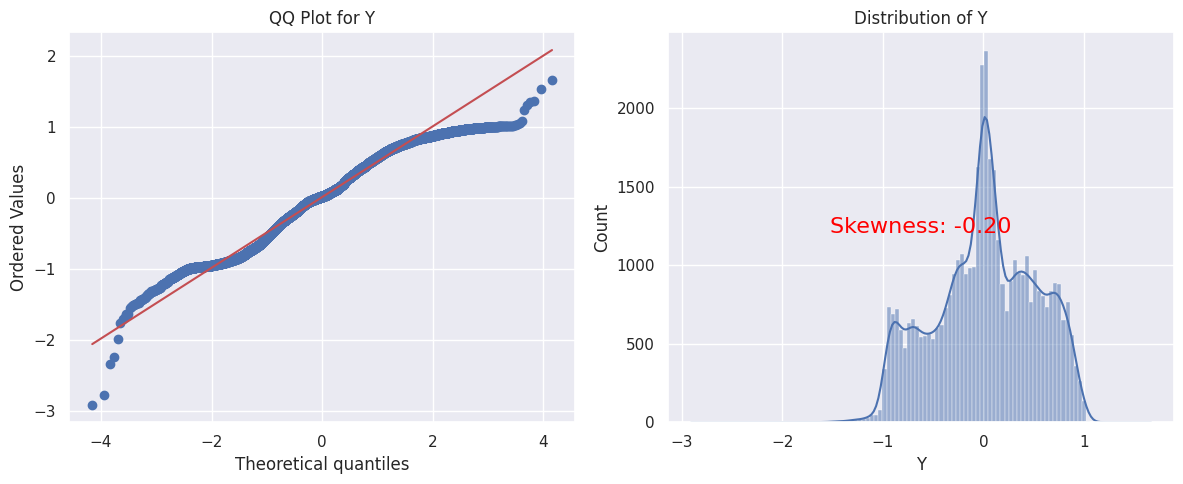

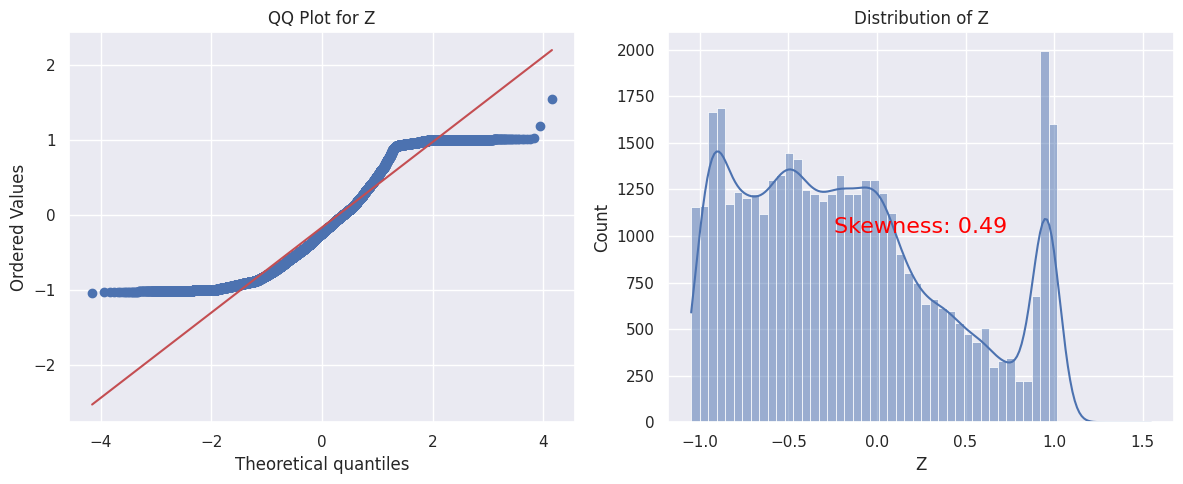

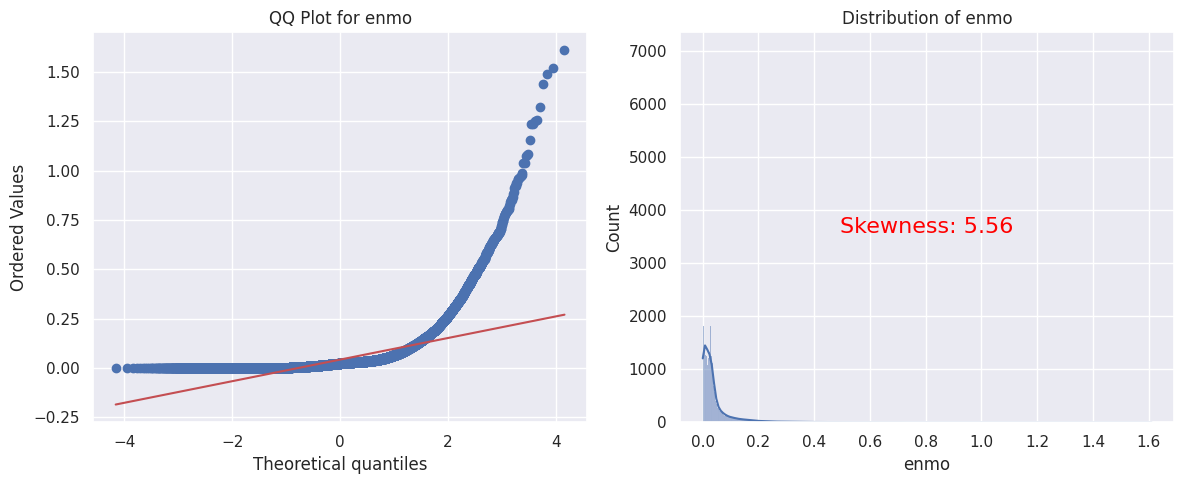

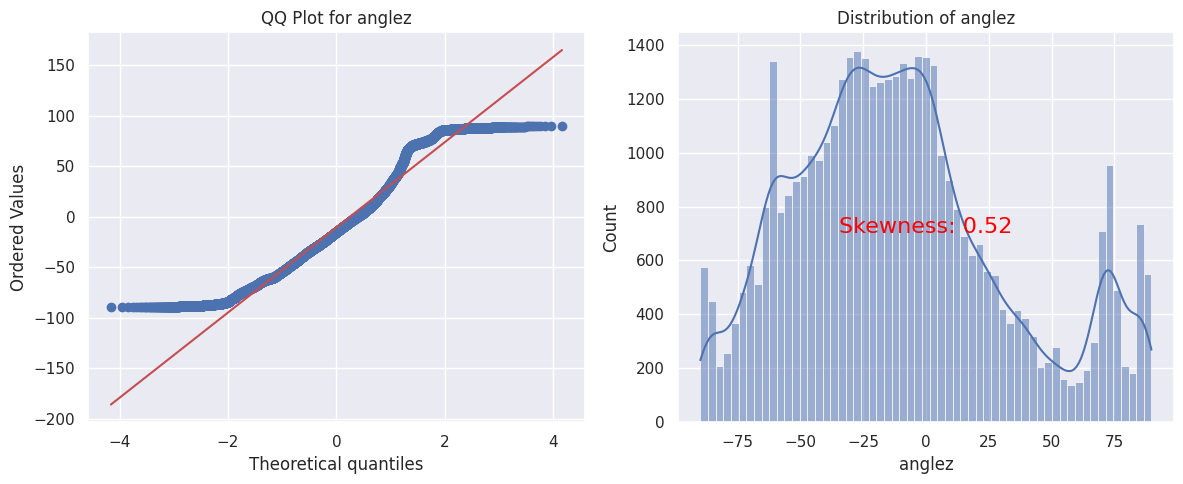

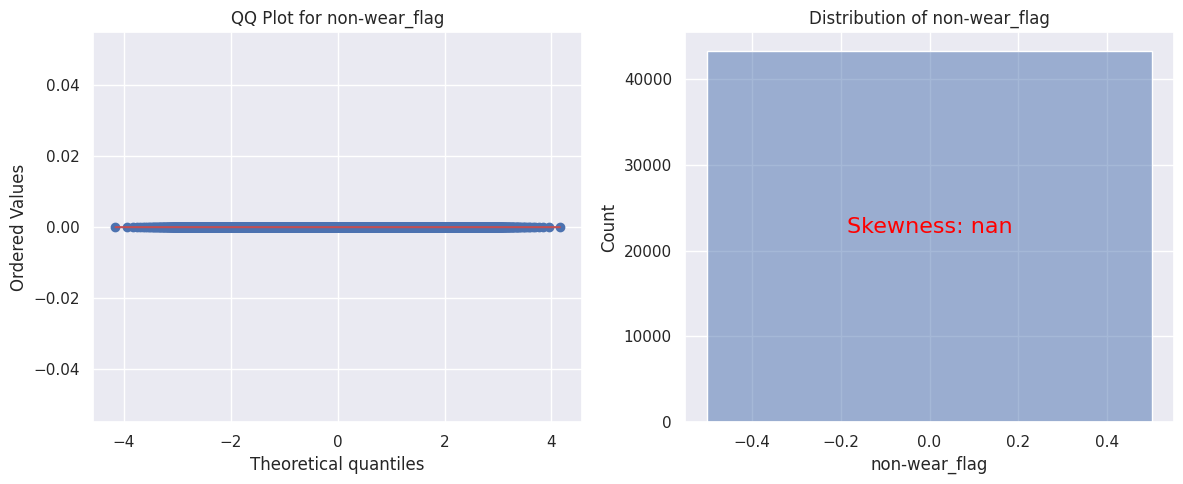

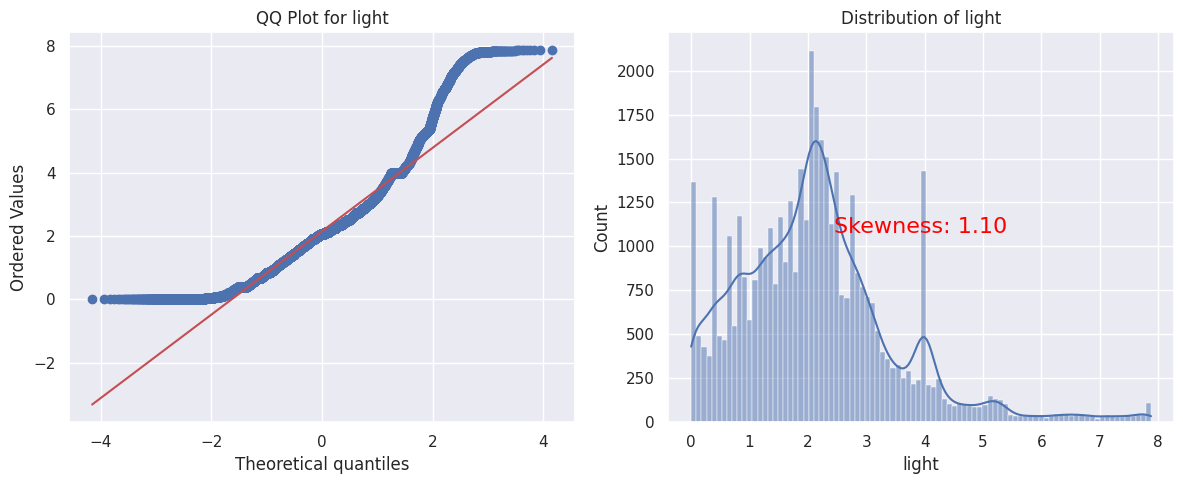

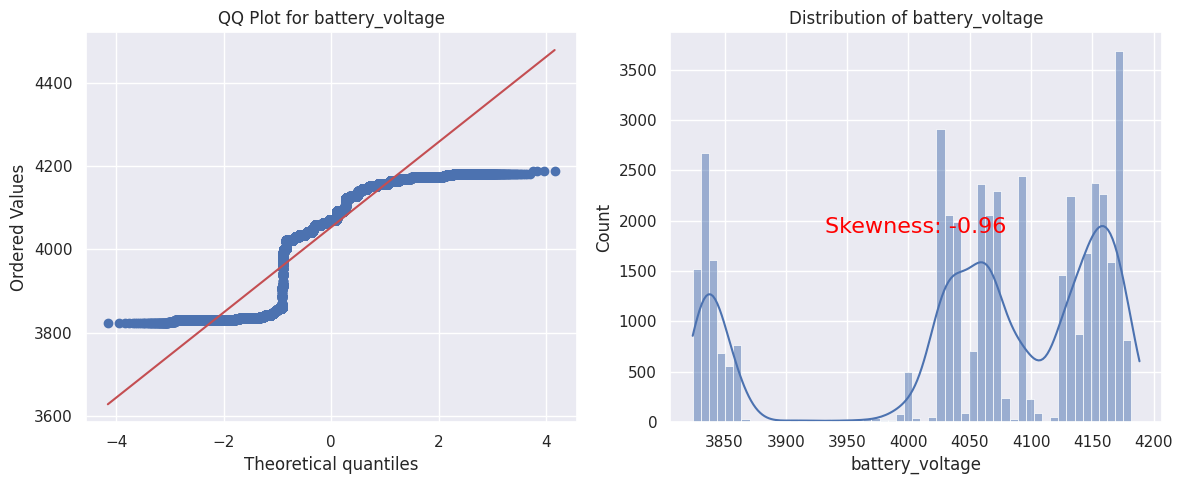

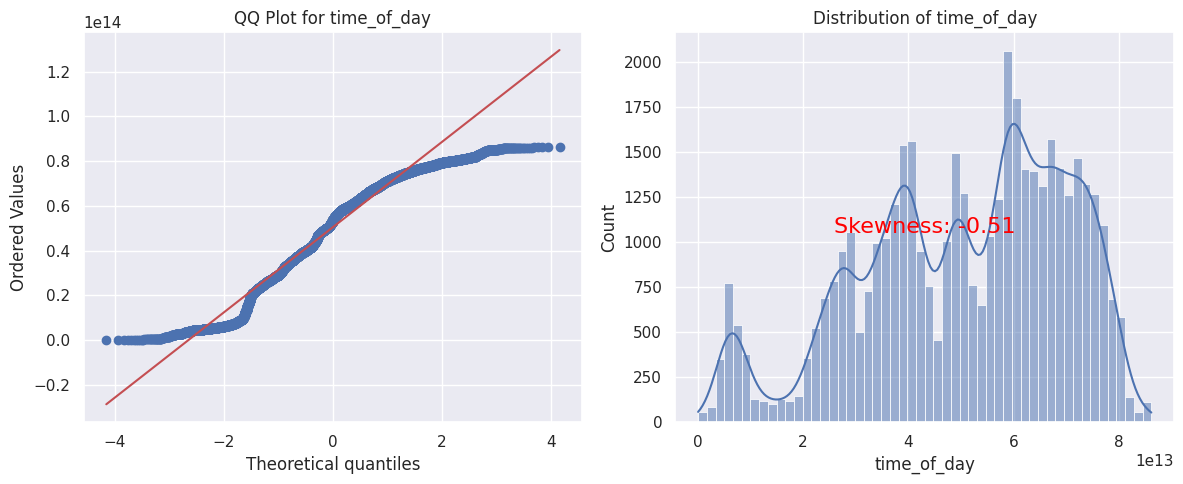

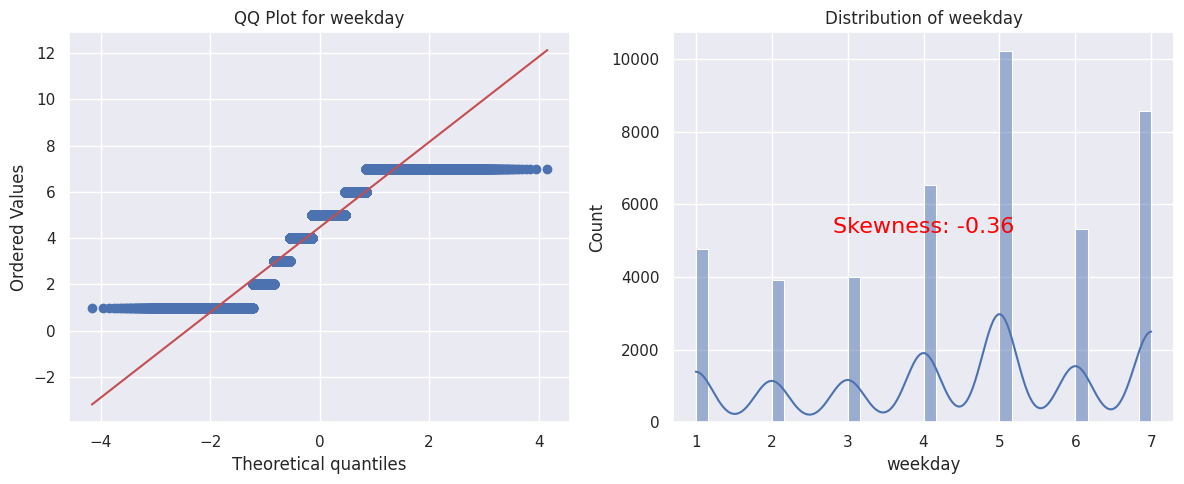

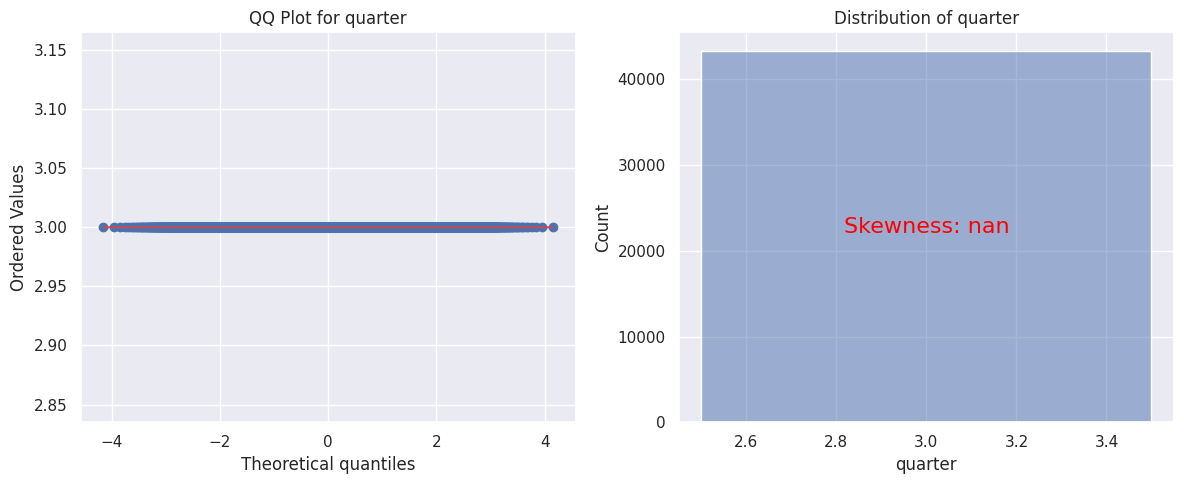

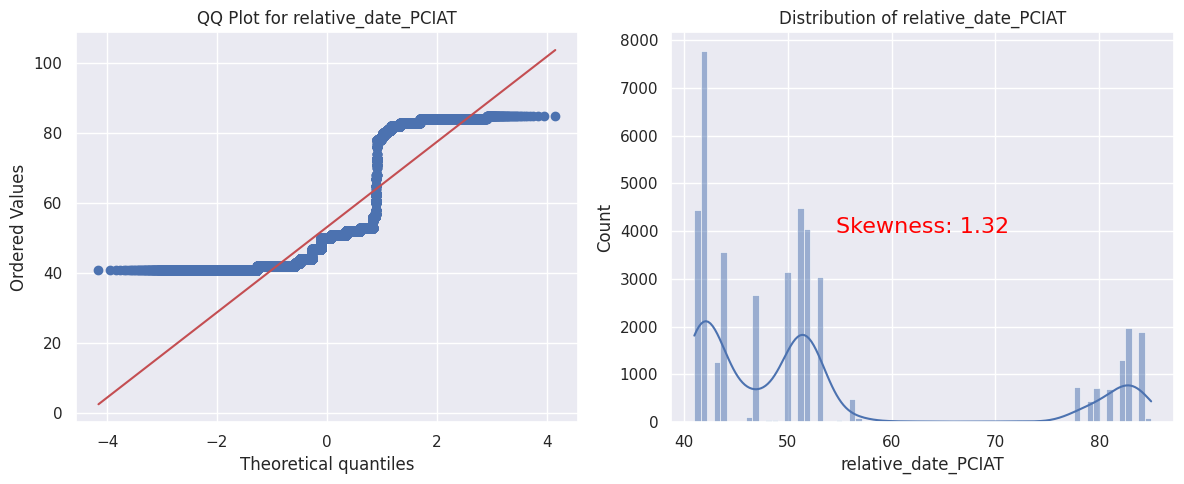

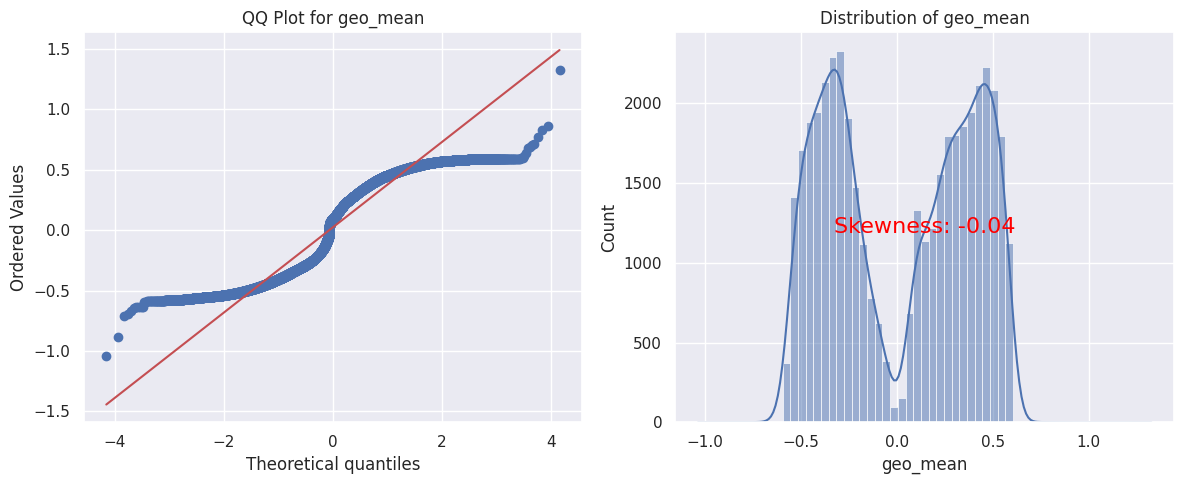

In [11]:
def qq_and_skewness_plots(data, num_col):
    
    f, ax = plt.subplots(1, 2, figsize=(12, 5))

    # QQ plot
    stats.probplot(data[num_col], dist="norm", plot=ax[0], fit=True)
    ax[0].set_title(f'QQ Plot for {num_col}')

    # Skewness plot
    sns.histplot(data[num_col], kde=True, ax=ax[1])
    ax[1].set_title(f'Distribution of {num_col}')

    # Calculate skewness value
    skewness_value = stats.skew(data[num_col])

    # Display skewness value on the plot
    ax[1].text(0.5, 0.5, f'Skewness: {skewness_value:.2f}', transform=ax[1].transAxes, 
               horizontalalignment='center', verticalalignment='center', fontsize=16, color='red')

    plt.tight_layout()  # Adjust spacing between subplots

    plt.show()

for col in df.columns:
    qq_and_skewness_plots(df, col)

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Q2.How are the numerical variables varied in response to time_of_day and weekday?</p>

Take 'X' for example. On Monday the object is most active at later time. From Tuesday to Sunday, active across all day long. Super active after lunch on Friday to Sunday. Similar patterns are observed for both 'Y' and 'Z'.

<Axes: xlabel='time_of_day', ylabel='X'>

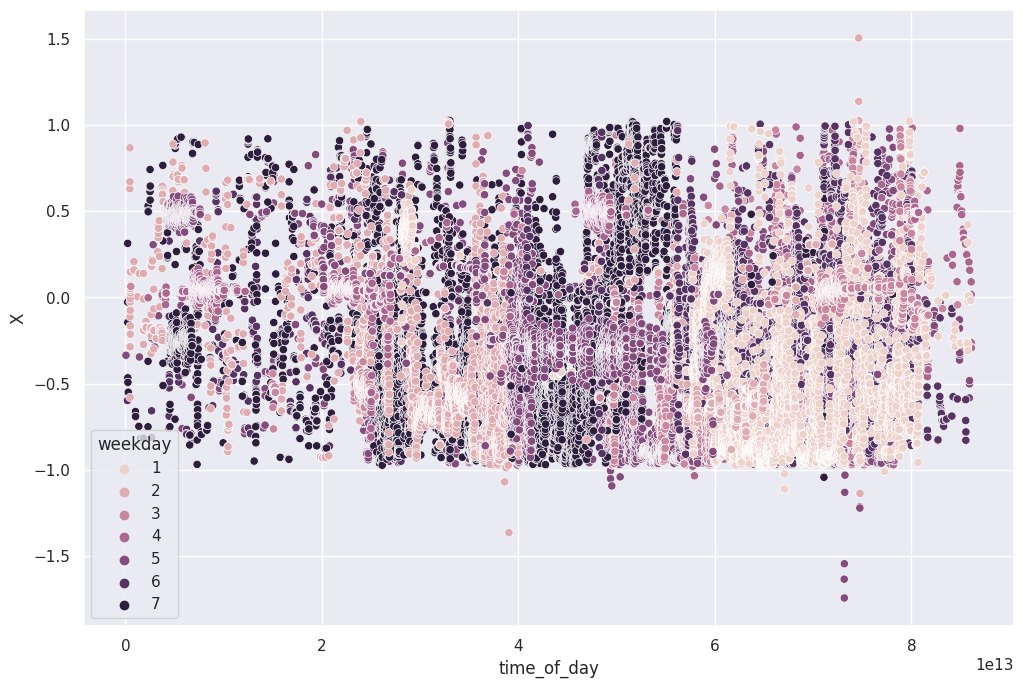

In [12]:
sns.set_theme(rc={'figure.figsize':(12,8)})
plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='time_of_day', y='X', hue='weekday')

Highest 'enmo's are recorded at later time on Thursday and Friday.

<Axes: xlabel='time_of_day', ylabel='enmo'>

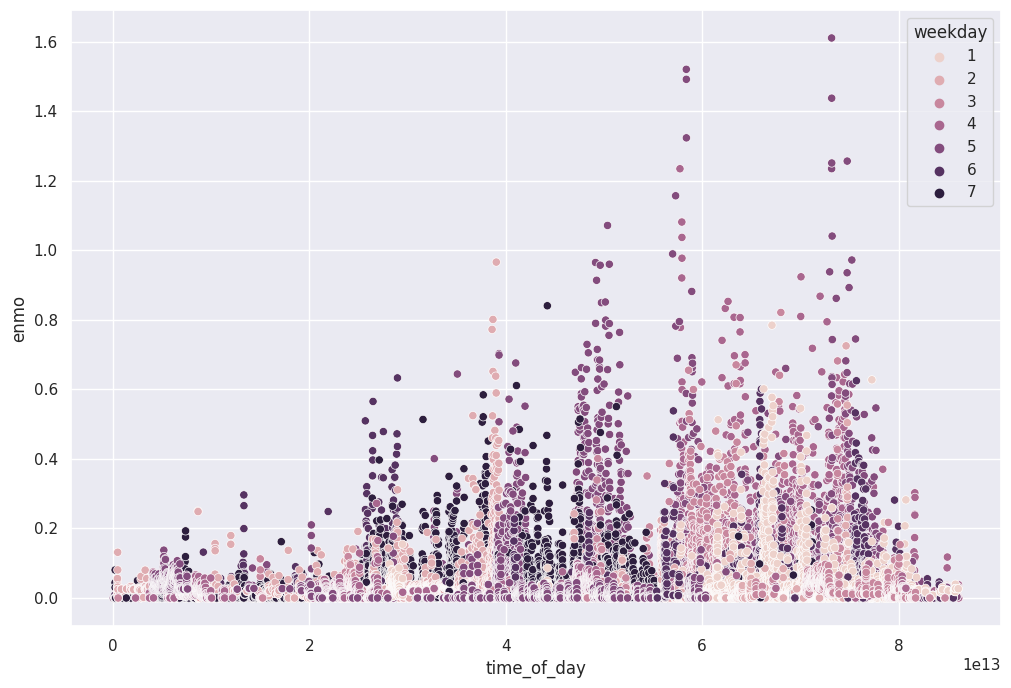

In [13]:
sns.scatterplot(data=df, x='time_of_day', y='enmo', hue='weekday')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Q3 How many counts do numerical features have by weekdays?</p>

Take 'X' for example. Its distribution is not even across seven days. Friday is the most. Sunday comes second. Tuesday and Wednesday are the fewest.

In [14]:
df.groupby('weekday')['X'].count().reset_index()

,weekday,X
0,1,4780
1,2,3913
2,3,3996
3,4,6545
4,5,10223
5,6,5307
6,7,8566


This figure shows how all of the training samples are taken by weekdays. Friday is the most frequent one. Sunday comes second. Tuesday and Wednesday are the least.

<Axes: xlabel='weekday', ylabel='count'>

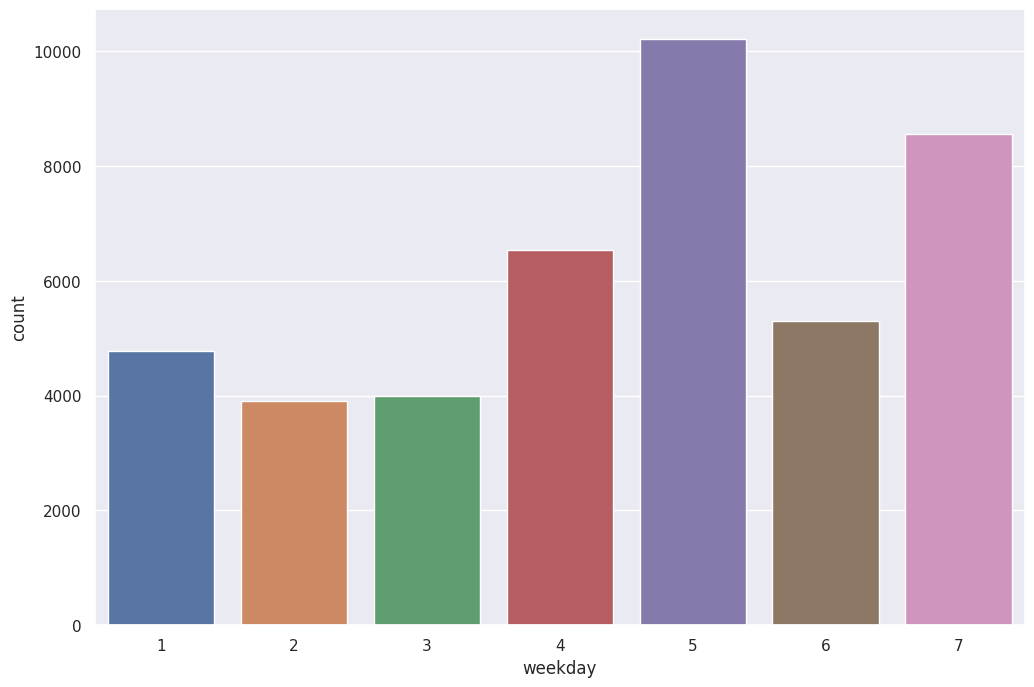

In [15]:
sns.countplot(data=df, x='weekday')

Separate 'relative_date_PCIAT' into several ranges. Most of the PCIAT tests were administered about 40 days ago. Tests administered about 60 days ago are the fewest.

In [16]:
df['relative_date_PCIAT_range'] = np.where(df['relative_date_PCIAT'].between(40, 50, inclusive='left'), '40s', 
                                     np.where(df['relative_date_PCIAT'].between(50, 60, inclusive='left'), '50s',
                                        np.where(df['relative_date_PCIAT'].between(60, 70, inclusive='left'), '60s',
                                           np.where(df['relative_date_PCIAT'].between(70, 80, inclusive='left'), '70s', '80+'))))

In [17]:
df.groupby('relative_date_PCIAT_range')['X'].count().reset_index()

,relative_date_PCIAT_range,X
0,40s,19907
1,50s,15345
2,60s,150
3,70s,1296
4,80+,6632


<Axes: xlabel='relative_date_PCIAT_range', ylabel='count'>

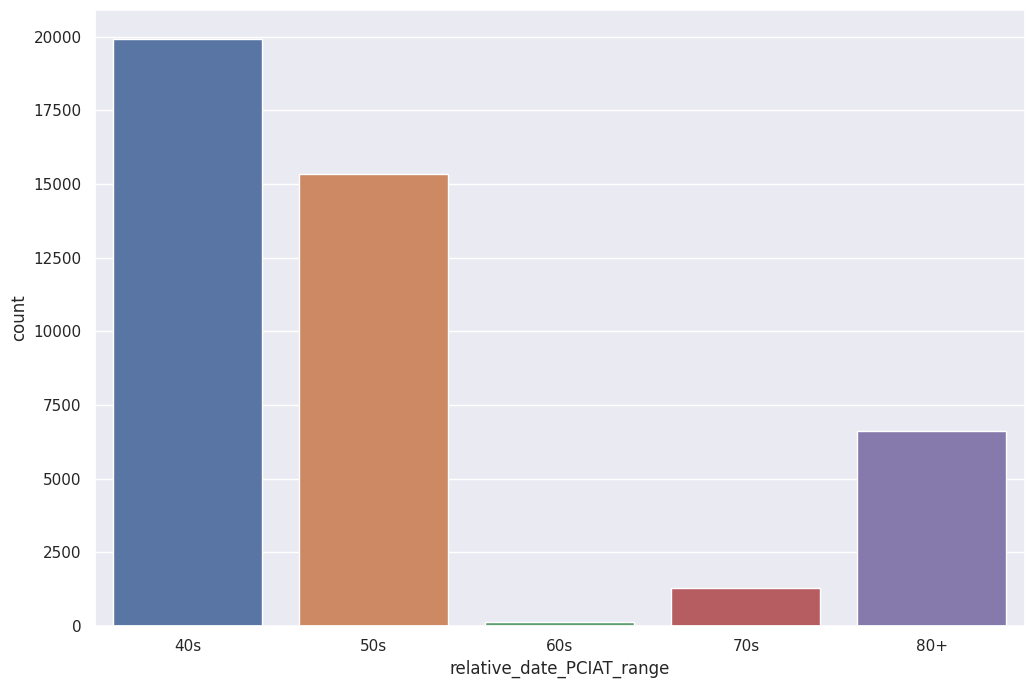

In [18]:
sns.countplot(data=df, x='relative_date_PCIAT_range')

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Q4 Other Interesting Plots.</p>

Pick three dimensions 'X', 'Y' and 'Z' and draw a 3D scatter plot. Most of the measurement data lie densely within an oval shaped area.

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


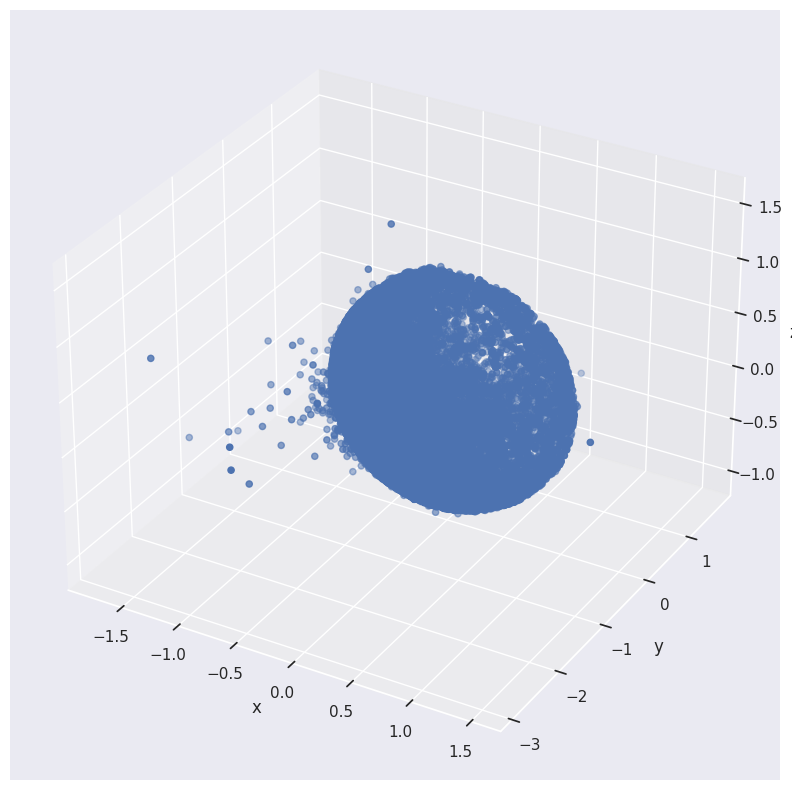

In [19]:
sns.set_style ("darkgrid")
plot_mean = 3

plot1 = df['X']
plot2 = df['Y']
plot3 = df['Z']

plt.figure (figsize = (15, 10))
seaborn_plot = plt.axes (projection='3d')
print (type (seaborn_plot))
seaborn_plot.scatter3D (plot1, plot2, plot3)
seaborn_plot.set_xlabel ('x')
seaborn_plot.set_ylabel ('y')
seaborn_plot.set_zlabel ('z')
plt.show ()

Pick two dimensions 'X' and 'Y' and draw a 2D contour plot.

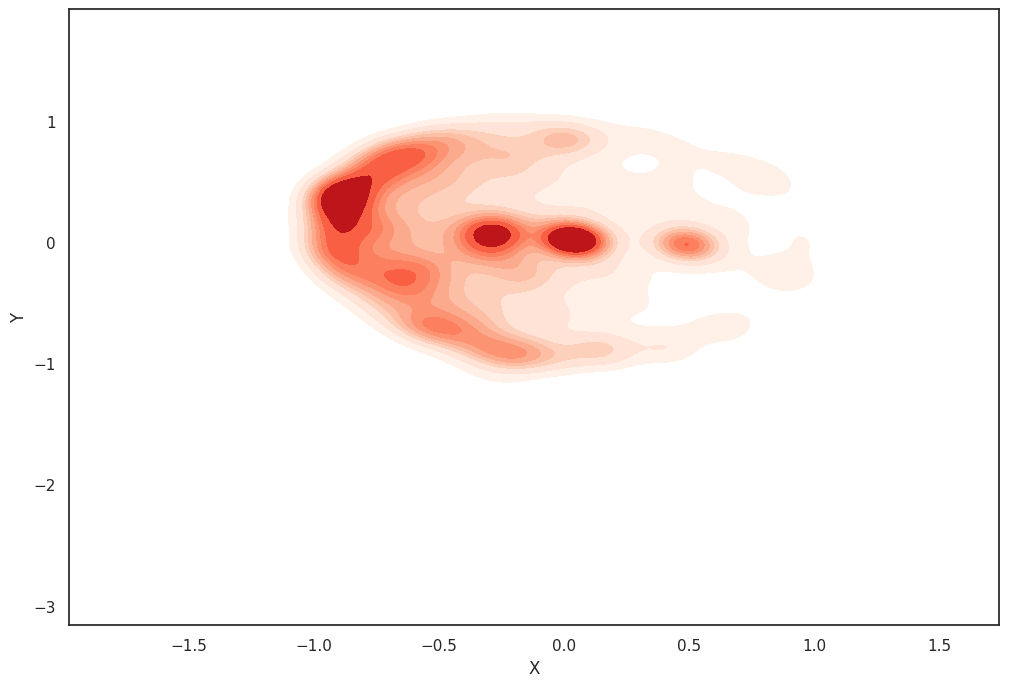

In [20]:
sns.set_style("white")
sns.kdeplot(x=df['X'], y=df['Y'], cmap="Reds", fill=True)
plt.show()

# <p style="background-color:#a7d14d;font-family:newtimeroman;color:#e609d3;font-size:150%;text-align:center;border-radius:20px 60px;">Conclusions.</p>

Four questions are answered through exploratory data analysis. This object is just the first example. Other objects may have similar or different patterns.